# JSON simulation language
For simple exchange of simulation descriptions a JSON format for the simulation was
developed. The files for the code examples are available from
https://github.com/matthiaskoenig/sbmlsim/tree/develop/docs/notebooks

In [1]:
%load_ext autoreload
%autoreload 2
import sbmlsim
print(sbmlsim.__version__)

0.1.0a1


## Timecourse simulation
In the first example we create a simple timecourse simulation for the repressilator model.
The simulation starts at `start` ends at `end` and has `steps` intervals (or `steps+1` points).

In [2]:
from sbmlsim.timecourse import Timecourse, TimecourseSim

tcsim = TimecourseSim(Timecourse(start=0, end=60, steps=60))

We can convert the timecourse simulation into JSON via

In [3]:
json_str = tcsim.to_json()
print(json_str)

{
  "timecourses": [
    {
      "start": 0,
      "end": 60,
      "steps": 60,
      "changes": {},
      "model_changes": {}
    }
  ],
  "selections": null,
  "reset": true
}


By providing a file path we can store the definition as json file

In [4]:
tcsim.to_json('./json_examples/example_1.json')

We can now run the simulation with a given model, here with the `repressilator` model and have a look at the numerical results.

In [5]:
from sbmlsim.simulation_serial import SimulatorSerial as Simulator

simulator = Simulator("./models/repressilator.xml")
result = simulator.timecourses(tcsim)
print(result)

<class 'sbmlsim.result.Result'>
DataFrames: 1
Shape: (61, 42, 1)
Size (bytes): 20496


In [6]:
# get timecourse data
result.mean.to_csv('./json_examples/example_1.tsv', index=False, sep='\t')
result.mean

,time,PX,PY,PZ,X,Y,Z,eff,n,KM,...,Reaction10,Reaction11,Reaction12,cell,[PX],[PY],[PZ],[X],[Y],[Z]
0,0.0,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,20.0,2.0,40.0,...,30.000000,30.000000,30.000000,1.0,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000
1,1.0,81.440426,188.382020,42.641364,19.903426,30.615526,7.491014,20.0,2.0,40.0,...,14.058083,5.854689,1.322932,1.0,81.440426,188.382020,42.641364,19.903426,30.615526,7.491014
2,2.0,218.538704,358.026782,84.588884,21.233519,23.608864,5.866252,20.0,2.0,40.0,...,5.506924,1.001491,0.399478,1.0,218.538704,358.026782,84.588884,21.233519,23.608864,5.866252
3,3.0,337.622362,469.625864,113.054468,18.544097,17.234851,4.403620,20.0,2.0,40.0,...,3.364327,0.444850,0.245856,1.0,337.622362,469.625864,113.054468,18.544097,17.234851,4.403620
4,4.0,428.938247,536.662776,131.034639,15.559775,12.482022,3.295798,20.0,2.0,40.0,...,2.584705,0.288379,0.195576,1.0,428.938247,536.662776,131.034639,15.559775,12.482022,3.295798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,56.0,218.684319,113.893055,1011.838390,0.257358,2.171448,11.909906,20.0,2.0,40.0,...,0.076763,1.000240,3.320778,1.0,218.684319,113.893055,1011.838390,0.257358,2.171448,11.909906
57,57.0,205.724492,121.680149,1021.009829,0.246437,2.434108,11.063379,20.0,2.0,40.0,...,0.075928,1.121739,2.952823,1.0,205.724492,121.680149,1021.009829,0.246437,2.434108,11.063379
58,58.0,193.568968,130.811333,1023.677923,0.238278,2.728748,10.156582,20.0,2.0,40.0,...,0.075690,1.257369,2.592688,1.0,193.568968,130.811333,1023.677923,0.238278,2.728748,10.156582
59,59.0,182.181259,141.421225,1019.972101,0.232563,3.058478,9.218230,20.0,2.0,40.0,...,0.076022,1.408327,2.250004,1.0,182.181259,141.421225,1019.972101,0.232563,3.058478,9.218230


Now we create a small helper for plotting the results which we will reuse in the following examples.

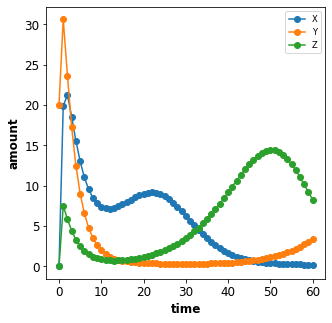

In [7]:
%matplotlib inline
from sbmlsim import plotting_matplotlib
from matplotlib import pyplot as plt

def plot_repressilator_result(result):
    df = result.mean
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    ax.plot(df.time, df.X, 'o-', label="X")
    ax.plot(df.time, df.Y, 'o-', label="Y")
    ax.plot(df.time, df.Z, 'o-', label="Z")

    ax.set_xlabel("time")
    ax.set_ylabel("amount")
    ax.legend()
    plt.show()
    
plot_repressilator_result(result)

## Model changes
A simulation without changing anything in the model is a bit boring, so in the following we add changes to the model at the beginning of a simulation.
Such changes can either be changes in the initial amount of a species, initial concentration of a species or parameter values. 

Changes are defined via the `changes` field in a timecourse. The referencing of model objects (species or parameters) works hereby via the `SId`, i.e. the SBML identifiers used in the SBML model.

### Parameter changes
To change parameter values add the assignment of the change to the `changes` dictionary.
In the example the parameter with id `n` is changed to `5` in the simulation by adding the changes `{'n': 5}` to the `Timecourse` object.

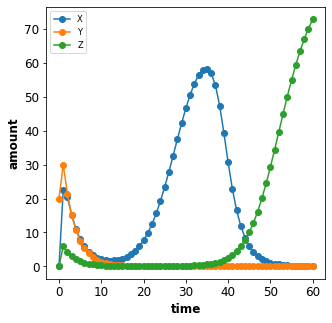

{
  "timecourses": [
    {
      "start": 0,
      "end": 60,
      "steps": 60,
      "changes": {
        "n": 5
      },
      "model_changes": {}
    }
  ],
  "selections": null,
  "reset": true
}


In [8]:
ex_id = 2
simulator = Simulator("./models/repressilator.xml")
tcsim = TimecourseSim(
    Timecourse(start=0, end=60, steps=60, changes={'n': 5})
)
result = simulator.timecourses(tcsim)
plot_repressilator_result(result)

tcsim.to_json(f'./json_examples/example_{ex_id}.json')
result.mean.to_csv(f'./json_examples/example_{ex_id}.tsv', index=False, sep='\t')
print(tcsim.to_json())

### Initial amount changes
To change the initial amount of a species `X` to `100` we add the corresponding changes `{'X': 100}` to the `Timecourse`.

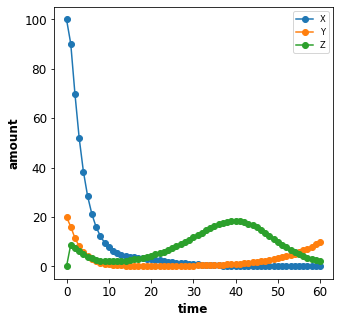

{
  "timecourses": [
    {
      "start": 0,
      "end": 60,
      "steps": 60,
      "changes": {
        "X": 100
      },
      "model_changes": {}
    }
  ],
  "selections": null,
  "reset": true
}


In [9]:
ex_id = 3
simulator = Simulator("./models/repressilator.xml")
tcsim = TimecourseSim(
    Timecourse(start=0, end=60, steps=60, changes={'X': 100})
)
result = simulator.timecourses(tcsim)
plot_repressilator_result(result)

tcsim.to_json(f'./json_examples/example_{ex_id}.json')
result.mean.to_csv(f'./json_examples/example_{ex_id}.tsv', index=False, sep='\t')
print(tcsim.to_json())

### Initial concentration changes
To change the initial concentration of a species `Y` to `50` in the simulation we add the changes `{'[Y]': 50}` to the `Timecourse`. The concentrations of species are referenced via the bracket syntax, i.e. `[Y]` is the concentration of `Y`, whereas `Y` is the amount of `Y`.

**Note:** For the repressilator model the volume in which the species are located is `1.0`, so that changes in amount correspond to changes in concentration.

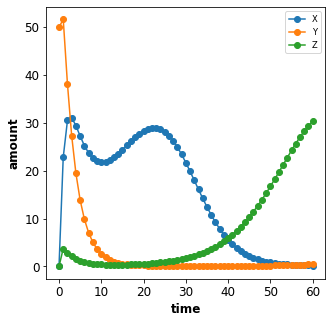

{
  "timecourses": [
    {
      "start": 0,
      "end": 60,
      "steps": 60,
      "changes": {
        "[Y]": 50
      },
      "model_changes": {}
    }
  ],
  "selections": null,
  "reset": true
}


In [10]:
ex_id = 4
simulator = Simulator("./models/repressilator.xml")
tcsim = TimecourseSim(
    Timecourse(start=0, end=60, steps=60, changes={'[Y]': 50})
)
result = simulator.timecourses(tcsim)
plot_repressilator_result(result)

tcsim.to_json(f'./json_examples/example_{ex_id}.json')
result.mean.to_csv(f'./json_examples/example_{ex_id}.tsv', index=False, sep='\t')
print(tcsim.to_json())

### Combined changes
All these elementary changes can be combined and are all applied at the beginning of the `Timecourse`. For instance to change the amount of `X` to `100`, the parameter `n` to `5` and the concentration of `[Y]` to `50` use the changes
```
changes={'n': 5, 'X': 100, '[Y]: 50}
```

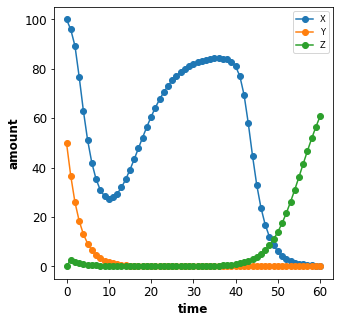

{
  "timecourses": [
    {
      "start": 0,
      "end": 60,
      "steps": 60,
      "changes": {
        "n": 5,
        "X": 100,
        "[Y]": 50
      },
      "model_changes": {}
    }
  ],
  "selections": null,
  "reset": true
}


In [11]:
ex_id = 5
simulator = Simulator("./models/repressilator.xml")
tcsim = TimecourseSim(
    Timecourse(start=0, end=60, steps=60, changes={'n': 5, 'X': 100, '[Y]': 50})
)
result = simulator.timecourses(tcsim)
plot_repressilator_result(result)

tcsim.to_json(f'./json_examples/example_{ex_id}.json')
result.mean.to_csv(f'./json_examples/example_{ex_id}.tsv', index=False, sep='\t')
print(tcsim.to_json())

## Combined timecourses
Multiple `Timecourse` objects can be combined to one large timecourse. The results  of the individual `Timecourse` are thereby concatenated. The `changes` are always applied at the beginning of the individual `Timecourse` simulations. 

The model state is persistent in the multiple timecourses, i.e. the end state of the state variables of one Timecourse are the starting values of the next Timecourse (with exception of state variables affected by changes).

An example will demonstrate what is meant by this. The complete timecourse simulation consists of 3 `Timecourse` parts:

* start the first Timecourse with an initial amount of `X=20` and simulate for 120 time steps
* set `n=20` in the model (while keeping the current state of all state variables) and continue simulating for 240 steps
* set `n=2` (this is the initial value of n) and continue simulating for another 240 steps

The result is a single timecourse simulation consisting of 3 timecourse parts.

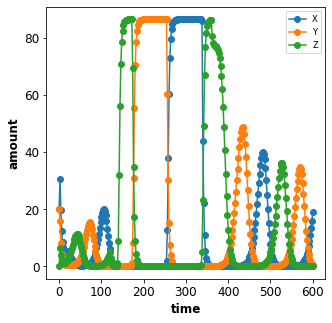

{
  "timecourses": [
    {
      "start": 0,
      "end": 120,
      "steps": 60,
      "changes": {
        "X": 20
      },
      "model_changes": {}
    },
    {
      "start": 0,
      "end": 240,
      "steps": 120,
      "changes": {
        "n": 20
      },
      "model_changes": {}
    },
    {
      "start": 0,
      "end": 240,
      "steps": 120,
      "changes": {
        "n": 2
      },
      "model_changes": {}
    }
  ],
  "selections": null,
  "reset": true
}


In [12]:
ex_id = 6
simulator = Simulator("./models/repressilator.xml")
tcsim = TimecourseSim([
    Timecourse(start=0, end=120, steps=60, changes={'X': 20}),
    Timecourse(start=0, end=240, steps=120, changes={'n': 20}),
    Timecourse(start=0, end=240, steps=120, changes={'n': 2}),
])
result = simulator.timecourses(tcsim)
plot_repressilator_result(result)

tcsim.to_json(f'./json_examples/example_{ex_id}.json')
result.mean.to_csv(f'./json_examples/example_{ex_id}.tsv', index=False, sep='\t')
print(tcsim.to_json())

## Fields overview
The following fields are available for `TimecourseSim`:

* `selections`: which columns should be stored in the output
* `reset`: should the model be reset at the beginning of a TimecourseSim (default=True)

The following fields are available for `Timecourse`:

* `start`: start time of integration
* `end`: end time of integration
* `steps`: steps in the integration, the final output has `steps+1` points
* `changes`: dictionary of changes applied at the beginning of timecourse simulation
* `model_changes`: `depecrated` can be ignored